# Rough Unit Sizing

Contained herein are *rough* mass balances, which *might* give us an idea what technologies *cannot* be used for PCC with encapsulated $K_2CO_3$ solvents.

## Everexpanding List of Assumptions:

Kinetically Optimized Fluidized Bed Calculations
- Particle Density ~ Density of Water (1g/cc)
- Fluid Density/Viscosity ~ Air Density/Viscosity @ 50 C
- 400 micron particles
- All particles fully regenerated at all times (maximizing reaction rate)
- Minimal gas-phase resistance
- Isothermal


## Fluidized Beds

First we must calculate the *minimum fluidization velocity*. We use the correlation from *Perry's* (originally from Wen and Yu, 1966):

$$Re_{mf} = (1135.7 + 0.0408Ar)^{0.5}-33.7$$
where
$$Re_{mf} = \bar{d}_p \rho_f U_{mf}/\mu$$

$$Ar = \bar{d}_p^3 \rho_f (\rho_s-\rho_f)g/\mu^2$$

where $\bar{d}_p$ is the Sauter mean diameter, $\rho_{f}$ and $\rho_{s}$ are the fluid and solid densities respectively, $\mu$ is the dynamic viscosity of the fluid, $g$ is the gravity constant, and $U_{mf}$ is the minimum fluidization velocity.

The method is simple: find the Archimedes number ($Ar$), then find the minimum-fluidization Reynold's number ($Re_{mf}$), and lastly rearrange this to give $U_{mf}$.

In [99]:
#Data
rho_f = 1.1      #kg/m3. Use air Density @50 C. Temperature taken from Oyenekan and Rochelle 2006; Data from http://www.engineeringtoolbox.com/air-density-specific-weight-d_600.html
rho_s = 1000     #kg/m3. Assume particle density ~ water density.
dp = 400e-6      #m, Sauter mean diameter of particles
g = 9.81         #m/s2, Gravity constant.
mu = 2.0e-5      #kg/m.s, Use air viscosity @350 K. Temperature from Oyenekan and Rochelle, 2006. Data from http://www.engineeringtoolbox.com/dry-air-properties-d_973.html

#Calculate Archimedes Number
Ar = dp^3 * rho_f * (rho_s-rho_f) * g / mu^2 

#Calculate Minimum Fluidization Reynold's Number
Re_mf = (1135.7 + 0.0408 * Ar)^0.5 - 33.7

#Calculate minimum fluidization velocity
U_mf = Re_mf * mu / (dp * rho_f)
println("The Minimim Fluidization velocity is $(round(U_mf,4)) m/s")

The Minimim Fluidization velocity is 0.0467 m/s


This seems quite small: only about 5 cm/s to fluidize these 400 micron particles. I'll try an alternative method.

### Minimum Fluidization Velocity: Take 2.

According to Ullman's article on *Fluidized-bed Reactors*, the minimum fluidization velocity, $u_{mf}$ is the superficial velocity where the *packed bed* pressure drop, given by the Ergun Equation,

$$\frac{\Delta P}{h} = 4.17S_v^2 \frac{(1-\varepsilon)^2}{\varepsilon^3} \eta u + 0.29 S_v \frac{1-\varepsilon}{\varepsilon^3}\rho_f u^2,$$

is equal to the *fluidized bed* pressure drop, which is dominated by the force required to suspend the particles,

$$\frac{\Delta P}{h} = (1-\varepsilon)(\rho_s-\rho_f)g.$$

Setting these pressure drops equal and solving for $u_{mf}$ gives:

$$u_{mf} = 7.14(1-\varepsilon_{mf})\nu S_v \left(\sqrt{1+0.067 \frac{\varepsilon_{mf}^3}{(1-\varepsilon_{mf})^2}\frac{(\rho_s-\rho_f)g}{\rho_f \nu^2 S_v^3}}-1\right)$$

For our encapsulated solvents, the only unknown is the voidage of the bed at fluidization, $\varepsilon_{mf}$, so we'll express $u_{mf}$ as a function of $\varepsilon_{mf}$.

In [98]:
#Data
nu_air = 2e-5   #kg/m.s, Use kinematic viscosity of air @350 K. Temperature from Oyenekan and Rochelle, 2006. Data from http://www.engineeringtoolbox.com/dry-air-properties-d_973.html
dp     = 400e-6 #m, Particle Diameter
rho_s  = 1000   #kg/m3, Particle Density (assumed equal to water)
rho_f  = 1.1    #kg/m3, Use density of air at 50 C. Temperature taken from Oyenekan and Rochelle 2006; Data from http://www.engineeringtoolbox.com/air-density-specific-weight-d_600.html
g      = 9.81   #m/s^2, Gravitational Constant

#Specific Surface Area
Sv = 6/dp       #Specific surface area, m^2/m^3

#Minimum fluidization velocity as a function of fluidized bed voidage
u_mf(eps) = 7.14(1-eps).*nu_air.*Sv.*(sqrt(1+0.067*eps.^3./(1-eps).^2*(rho_s-rho_f)*g/(rho_f*nu_air^2*Sv^3))-1);

We'll make a plot of $u_{mf}$ vs $\varepsilon$ to check its sensitivity:

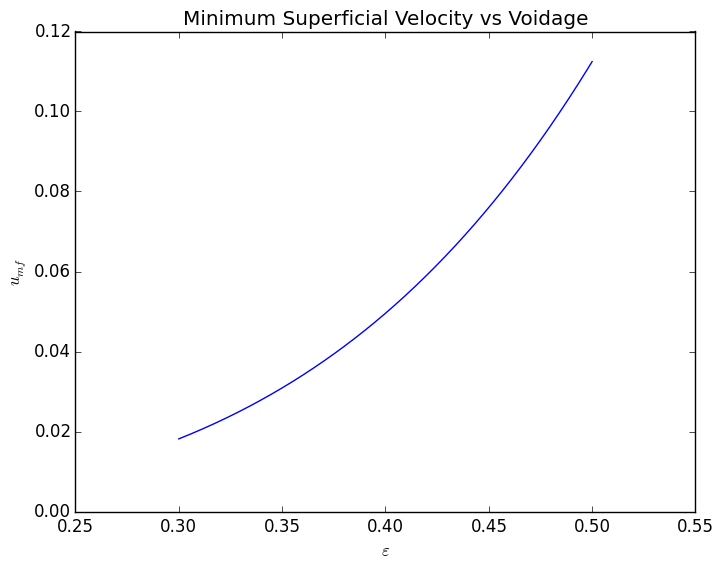

In [65]:
using PyPlot
epsrange = linspace(0.3,0.5,1000)
plot(epsrange, u_mf(epsrange))
xlabel(L"$\varepsilon$")
ylabel(L"$u_{mf}$");
title("Minimum Superficial Velocity vs Voidage");

Wen and Yu (1966) claim that for spherical particles $\varepsilon_{mf}$ can vary from 0.36 to 0.46, and Kunii, in *Fluidization Engineering*, cites a value of 0.41 for spherical sand particles. Using Kunii's value:

In [66]:
u_mf(0.41)

0.054152925520264204

Which is almost exactly what the correlation in Perry's gives us. Indeed, if $\varepsilon_{mf} \approx 0.39$, a reasonable value, we get the exact same result. We'll thus run with the value of 5 cm/s. EDIT: I later found, in Kunii's book, that method 1 is derived from method 2 under simplifying assumptions. 

### What's a Realistic *Operating* Velocity?

We've found the *minimum* fluidization velocity to be about 5 cm/s. To compare this with the operating velocity, we'll use this chart from Grace's 1986 paper *Contacting Modes and Behaviour Classification of Gas-Solid and Other Two-Phase Suspensions:*
<img src="Gracechart.png">

Here the x-axis is $Ar^{1/3}$ and the y-axis is $Re/Ar^{1/3}$. At minimum fluidization, our values are:

In [58]:
println(Ar^(1/3))
println(Re_mf/Ar^(1/3))

11.992265349002281
0.08576054849599128


Which fit nicely in the 'minimum fluidization range' (they did use the same correlation as us, after all!) It's also good to see that our Archimedes number sits right in the middle of the typical operating ranges. With the value $d_P^* \approx 12$, we see that $U^*$ takes on values 0.3-2.0 for *conventional fluidized beds* and 4-15 for *circulating fluidized beds.* We convert this to a superficial velocity $u$ using:

$$U^* = \frac{Re}{Ar^{1/3}} = \frac{\bar{d}_p \rho_f u}{\mu}\frac{1}{Ar^{1/3}}$$

Rearranging:

$$u = U^* \frac{Ar^{1/3} \mu}{\bar{d}_p \rho_f }.$$

For a conventional fluidized bed:

In [100]:
umin_fb = 0.3 * Ar^(1/3) * mu / (dp*rho_f)       #m/s
umax_fb = 2.0 * Ar^(1/3) * mu / (dp*rho_f)       #m/s
println(umin_fb)
println(umax_fb)

0.16353089112275837
1.090205940818389


For a circulating fluidized bed:

In [103]:
umin_cfb = 4.0 * Ar^(1/3) * mu / (dp*rho_f)       #m/s
umax_cfb = 15  * Ar^(1/3) * mu / (dp*rho_f)       #m/s
println(umin_cfb)
println(umax_cfb)

2.180411881636778
8.17654455613792


These values also seem consistent with the Aines' group *Nature* paper: their video of the fluidized particles used a superficial velocity of 1.6 m/s, and they had significant particle entrainment. They are certainly fast, but they don't seem ludicrous. However, combined with the slow kinetics and the high $CO_2$ concentration, they might prove too fast.

## How big is our Fluidized Bed going to be?

This is a difficult question. To start, the question is not fully defined, as their are lots of parameters we can optimize, the most obvious of which is the residence time. Broadly speaking, our bed could operate in two modes:
- Kinetics limited
- Thermodynamics/particle recycle rate limited.

In the first situation, we need a high bed *because gas absorption is slow, and we need a large gas-particle contact time to ensure we reach our gas-concentration targets*. In the second mode, the kinetics are lightning fast, and our particles quickly get saturated. Thus we either *build a higher column* (note - wider columns don't help as our superficial velocity is fixed) or we *recycle particles quicker*, or some combination of the two.

In reality, we'll (probably) want to operate somewhere between these extremes. We want to find a column height where the gas contact time is sufficiently long, but we'll also need to have at least *some* noticeable saturation of particles (with associated drop in reaction kinetics, leading, of course, to a higher column). Ultimately, the balance will be between minimizing column height and minimizing particle recirculation rate. Column height costs money in capital costs and pressure drop; particle recirculation rate costs money in capital cost and regeneration energy. We'll try to find a happy balance.

All that said, it seems likely that kinetics are our main concern. The gas is veritably flying through our bed: we have slow reaction kinetics and little reaction time. We'll assume *infinitely short particle residence times* (so all particles are fully regenerated at all times, maximizing the reaction rate) and see how high a single column would need to be.


## Column with Maximal Kinetics

We'll use a 3 wt% $K_2CO_3$, for the sole reason that Vericella's *Nature* paper gives us all the kinetic data we need. In particular, the initial $CO_2$ absorption rate into these microcapsules (before saturation begins to set in) is given by:

$$\frac{dn_{CO_2}}{dt} = \left(\frac{PK_H\sqrt{Dk_{OH}[OH^-]}}{P+LK_H\sqrt{Dk_{OH}[OH^-]}}\right)Ap_{CO_2}$$

where $A$ is the surface area, $P$ is the membrane permeability, $K_H$ is the Henry's constant, $D$ is the diffusivity of $CO_2$, $L$ is the wall width, $p_{CO_2}$ is the $CO_2$ partial pressure, and $k_{OH}$ is the second-order rate constant for the (rate-controlling) reaction:

$$CO_2 + OH^- \rightarrow {HCO_3}^{-}.$$

With our assumption that all particles are fully regenerated, everything in the brackets is constant. We thus have:

$$\frac{dn_{CO_2}}{dt} = C_1 \cdot A \cdot p_{CO_2}.$$

Let's evaluate this using the data in the supplementary materials of the Nature paper.


In [110]:
P = 1.07e-12          #mol.m/(m2.s.Pa), Permeability of membrane
KH = 2.88e-4          #mol/(Pa.m3), Henry's constant of CO2 above solution
D = 1.78e-9           #m2/s, Diffusivity of CO2 in solution
L = 30e-6             #m, Assumed shell thickness: Nature paper gives range of 10-50 micron
kOH = 8.76            #m3/(mol.s) Second order reaction rate constant.
C_OH = 8.2e-5         #mol/m3, concentration of hydroxide ions in solution

C1 = (P*KH*sqrt(D*kOH*C_OH))/(P+L*KH*sqrt(D*kOH*C_OH))   #mol/s.m.Pa

3.2271124290811517e-10

## Mass Balance

We assume ideal gas behaviour, isothermal operation, and plug flow in the gas phase. We also ignore any changes in superficial velocity caused by the absorption of $CO_2$ (i.e. 15% counts as 'dilute enough'). 

We take as control volume a horizontal slice through our reactor: it's bottom is at height $z$, it's top at height $z + \Delta z$.

**Flux in.**

At a height $z$, the flux of $CO_2$ is:

$$N_z = u\cdot A_{cs} \cdot C_{CO_2,z} = u\cdot A_{cs} \cdot\left(\frac{p_{CO2,z}}{RT}\right) \equiv \frac{uA_{cs}}{RT}p_{z}$$

where $A_{cs}$ is the crossectional area, and we write $p_z \equiv p_{CO2,z}$ for the time being.

**Flux Out**

Similarly, at the height $z + \Delta z$ we have

$$N_{z+\Delta z} = \frac{uA_{cs}}{RT}p_{z+\Delta z}$$

**CO2 Absorbed**

The gas phase also loses some $CO_2$ as it is absorbed. We saw before that (remembering that $p \equiv p_{CO_2}$):

$$\frac{dn_{CO_2}}{dt} = C_1 \cdot A \cdot p$$

The only unknown here is the surface area $A$ in our unit volume. This depends on the voidage $\varepsilon$, which we won't specify just yet. The volume of spheres in our region from $z$ to $z+\Delta z$ is

$$ \text{Capsule Volume in Small Region} = \Delta z A_{cs} (1-\varepsilon)$$

and for spheres the surface area is given by

$$\text{Area} = \frac{6}{d_p} \text{Volume}$$

And so in our region, the surface area is:

$$A = \frac{6}{d_p}\Delta z A_{cs} (1-\varepsilon)$$

and finally,

$$\frac{dn_{CO_2}}{dt} = \frac{6C_1  A_{cs} (1-\varepsilon)\Delta z}{d_p} \cdot p.$$

**Mass Balance**

We have overall

$$N_z = N_{z+\Delta z} + \frac{dn_{CO_2}}{dt} $$

Subbing everything in,

$$\frac{uA_{cs}}{RT}p_{z} = \frac{uA_{cs}}{RT}p_{z+\Delta z} + \frac{6C_1  A_{cs} (1-\varepsilon)\Delta z}{d_p} \cdot p.$$

Rearranging a little, cancelling the $A_{cs}$, and taking $\Delta z \rightarrow 0$, we get

$$\frac{dp}{dz} = -\frac{6C_1  RT (1-\varepsilon)}{ud_p} \cdot p$$

And under the assumptions above (specifically of constant $u$ and $T$)

$$\frac{dp}{dz} = -\alpha p$$

and

$$p(z) = p_o e^{-\alpha z}.$$

To achieve 90% removal, we need $p = 0.1 p_0$, so the required column height $H$ would be

$$H = -\frac{\ln 0.1}{\alpha}.$$

Once we know the column height, $H$, we can calculate the required pressure drop via the equation:

$$\frac{\Delta P}{H} = (1-\varepsilon)(\rho_s-\rho_f)g.$$

### Different choices of $\varepsilon$ and $u$

We calculated above that, for our system, superficial velocities of 0.4 m/s and 3 m/s sit in the middle of the conventional and circulating fluidized bed regimes respectively. But what values should we choose for bed voidage in these regimes?

I'm just going to cite Louge's 1990 paper *Measurements of voidage near the wall of a circulating fluidized bed riser* and say the voidage for the conventional and circulating fluidized beds will be 0.6 and 0.75 respectively. Ultimately in our simple model voidage just scales the bed height, so if all we need is a reasonable guess for bed height, we only need a reasonable guess for bed voidage.

With these values for voidage, we are ready to evaluate the equations above and calculate the required bed height!

In [111]:
#New Data
R = 8.314       #J/K.mol Universal Gas Constant
T = 325         #K, The temperature value we've assumed so far
u_fb = 0.4      #m/s, superficial velocity of (conventional) fluidized bed
u_cfb = 3       #m/s, superficial velocity of circulating fluidized bed
eps_fb = 0.6    #Assumed Fluidized Bed Voidage
eps_cfb = 0.75  #Assumed Circulating Fluidized Bed Voidage

alpha_fb = 6*C1*R*T*(1-eps_fb)/(u_fb*dp)
alpha_cfb = 6*C1*R*T*(1-eps_cfb)/(u_cfb*dp)

H_fb = -log (0.1) / alpha_fb
H_cfb = -log (0.1) / alpha_cfb

Pdrop_fb = H_fb * (1-eps_fb) * (rho_s - rho_f) * g
Pdrop_cfb = H_cfb * (1-eps_cfb) * (rho_s - rho_f) * g
println("The fluidized bed height is $(round(H_fb,2)) m with p-drop of $(round(Pdrop_fb/1e6,3)) MPa")
println("The circulating fluidized bed height is $(round(H_cfb,2)) m with p-drop of $(round(Pdrop_cfb/1e6,3)) MPa")

The fluidized bed height is 176.04 m with p-drop of 0.69 MPa
The circulating fluidized bed height is 2112.51 m with p-drop of 5.175 MPa


These values are clearly unreasonable. Let's review our calculation; we assumed:
- Sufficient gas velocity to fluidize the particles.
- Perfect kinetics (all particles continually in unsaturated state; no gas-phase mass-transfer resisitance).

It seems that, at least for a bed of 400 micron particles containing 3 wt% $K_2CO_3$, *even theoretically perfect kinetics are not fast enough to capture enough (90%) of the gas-phase $CO_2$ in a reasonably sized column.*

# Improvements

We can get some more realistic values in a number of ways:

**Smaller particle size**

Smaller particles increase the specific surface area and decrease the required superficial velocity.

Following the exact same procedure for 100 micron particles (the smallest size given in the Vericella paper) I get an 11m high conventional fluidized bed column with a pressure drop of 43 kPa. For 200 micron particles, we get a height of 66m. These heights can be reduced to 5.5m and 22m respectively by operating the fluidized beds right at the lowest possible superficial velocity in the 'conventional fluidized bed' region on Darcy's chart. On the other hand, the smallest achievable circulating fluidized bed was still 176m high.

**Increase Reaction Rates (Higher Concentration/Catalysts/Higher Temperature)**

I'm not sure how much improvement can be hoped for here. With stronger solutions we'll get higher $[OH^-]$ concentrations (with the current setup, increasing $[OH^-]$ by a factor 10 decreased bed height by a factor of 4), and with catalysts and higher temperatures we may be able to increase the value of $k_{OH}$ significantly. 


### Final Thoughts

- The actual column height will likely need to be at least 2-3 times higher than this method predicts, becaues actual absorption rates will be significantly less when the slower kinetics are taken into account.
- While smaller particles may give better results, they are more expensive to make, and they may simply prove impossible to use. If this calculation categorically rules out larger particles (even with catalysts/higher temperatures/higher concentrations), it may rule out the fluidized bed option altogether.